# Getting started with Data Science

---

Whilst there's no template for solving a data science problem, we do go through similar steps in the different projects we take on. This notebook will follow through (and hopefully bring to life) the key steps of a data science project workflow.

** Key steps of a data science workflow**

1. Identify the problem
2. Obtain the data
3. Explore the data
4. Build a model
5. Communicate the results

This process is iterative and completely non-linear. Quite often as you dig deeper into the data you'll uncover new questions and problems to solve. 

### 1. Identify the problem
---

The first thing you need to do is to identify the problem and also **understand why it needs be solved**. You should think about the possible ways of solving this problem and ensure it is a problem that can be solved through data science. It's key to identify who the stakeholders are and what the business benefit is of solving this problem.

It's important to **define a success criteria** at the begining of your project, which is really helpful as it provides you with a **stopping point**. Data science projects are notorious for continuing on for too long. 

In this notebook we will be looking at a wine dataset which is related to red and white Vinho Verde wine samples, from the north of Portugal.

In the example we will be working through today, we will be trying to predict whether a wine is white or red.

### 2. Obtain the data

---

Data can come from all different sources, you might have your data available as a CSV (stored locally or in the cloud), you may need to query a relational database like SQL, or might need to scrape data from the web.

You'll need to think about whether you have enough data available, and whether the data is relevant to the research question. 

It's also important to identify the assumptions and limitations of the data you're working with. 

And finally can the data you're working with be supplemented with additional data? You could check what relevant publically available data you can find online. 

In this example the datasets that we are working with are in a CSV format, we are going to read them in directly from an online source using a package called Pandas. Pandas is a powerful and flexible python package for data manipulation and analysis. 

#### Imports & packages

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn import metrics, model_selection as ms, neighbors
from sklearn import tree, ensemble
from sklearn.preprocessing import StandardScaler

In [2]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix\n', cmap=plt.cm.PuBuGn):
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label\n', fontsize=14)
    plt.xlabel('Predicted label\n', fontsize=14)
    plt.show()

In [4]:
sns.set_palette('Set2', 8)

#### Reading in the datasets

In [5]:
WHITES_URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
REDS_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'

In [6]:
whites = pd.read_csv(WHITES_URL, sep=';')
reds = pd.read_csv(REDS_URL, sep=';')

### 3. Explore the data
---
This is an opportunity to really **understand** the data that you're working with. I rely heavily on Pandas to **manipulate, clean and inspect the data** I'm working with. I then use Matplotlib and Seaborn (two popular Python plotting libraries) to **visualise how the data is distributed**.

Exploratory data analysis (EDA) gives the data scientist an opportunity to really learn about the data they are working with. Many data scientists find themselves coming back to EDA and the findings they found later on in the process.

When working with a new dataset it is worth checking to see if any documentation is available. If available, this will help you to understand how the data was collected, what the different features are and any limitations of the data you are working with. 

At this point you should refer back to the problem that you're trying to solve. Is this **supervised** learning or **unsupervised** learning? Is this a **classification** problem or is it a **regression** problem? Is this a **prediction** problem or an **inference** problem?

_For this example, we are making a **prediction** (whether a wine is red or white) and we have **labelled training data** as we have training data where we know the colour of the wine, therefore it is a **supervised learning** problem. The thing we are predicting is **categorical** therefore we will be using a **classification algorithm**._


First we'll join the two datasets together, adding a new variable for colour

In [7]:
whites['colour'] = 'w'
reds['colour'] = 'r'

In [8]:
wine = pd.concat([whites, reds], axis=0, ignore_index=True)

Taking a subset of the features to simplify the problem.

In [9]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'colour'],
      dtype='object')

In [10]:
wine = wine[['fixed acidity', 'residual sugar', 'total sulfur dioxide', 'alcohol', 'colour']]

Now we can take a look at the first few lines of the dataset that we're working with.

In [11]:
wine.head()

,fixed acidity,residual sugar,total sulfur dioxide,alcohol,colour
0,7.0,20.7,170.0,8.8,w
1,6.3,1.6,132.0,9.5,w
2,8.1,6.9,97.0,10.1,w
3,7.2,8.5,186.0,9.9,w
4,7.2,8.5,186.0,9.9,w


What's the shape of the dataset?

In [12]:
wine.shape

(6497, 5)

What data types do we have?

In [14]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 5 columns):
fixed acidity           6497 non-null float64
residual sugar          6497 non-null float64
total sulfur dioxide    6497 non-null float64
alcohol                 6497 non-null float64
colour                  6497 non-null object
dtypes: float64(4), object(1)
memory usage: 253.9+ KB


Great, we don't have any missing values to deal with.   


Obviously this is rarely the case when working with data in real life, normally you'll have to think about how you're going to deal with **missing values, changing the data types or cleaning your data**. This can involve stripping characters from strings, converting integers to floats, or many other things.

This is normally the most time consuming part of any data science project. When working through the EDA process you learn about the data, and often highlight further things you need to fix in order to conduct your analysis. 

#### Exploring the data

Let's look at some summary statistics - can we identify clear differences between red and white wines

In [15]:
wine.groupby('colour').describe().T

colour                                r            w
alcohol              count  1599.000000  4898.000000
                     mean     10.422983    10.514267
                     std       1.065668     1.230621
                     min       8.400000     8.000000
                     25%       9.500000     9.500000
                     50%      10.200000    10.400000
                     75%      11.100000    11.400000
                     max      14.900000    14.200000
fixed acidity        count  1599.000000  4898.000000
                     mean      8.319637     6.854788
                     std       1.741096     0.843868
                     min       4.600000     3.800000
                     25%       7.100000     6.300000
                     50%       7.900000     6.800000
                     75%       9.200000     7.300000
                     max      15.900000    14.200000
residual sugar       count  1599.000000  4898.000000
                     mean      2.538806     6.391415
                     std       1.409928     5.072058
                     min       0.900000     0.600000
                     25%       1.900000     1.700000
                     50%       2.200000     5.200000
                     75%       2.600000     9.900000
                     max      15.500000    65.800000
total sulfur dioxide count  1599.000000  4898.000000
                     mean     46.467792   138.360657
                     std      32.895324    42.498065
                     min       6.000000     9.000000
                     25%      22.000000   108.000000
                     50%      38.000000   134.000000
                     75%      62.000000   167.000000
                     max     289.000000   440.000000

How many observations do we have of each colour?

In [16]:
wine['colour'].value_counts()

w    4898
r    1599
Name: colour, dtype: int64

**Visualising the data**

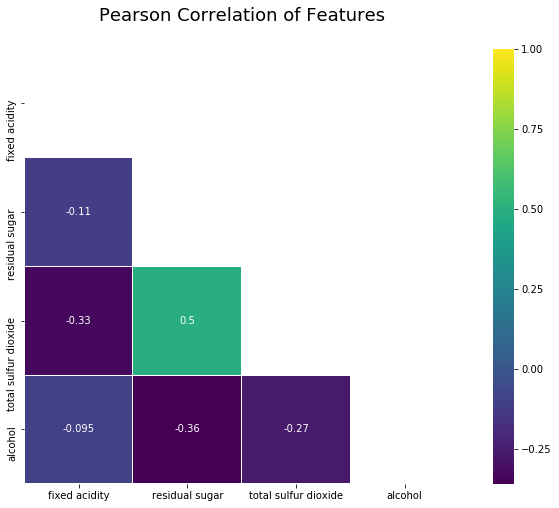

In [17]:
corr = wine.drop('colour', 1).astype(float).corr()
plt.figure(figsize=(12,8))
plt.title('Pearson Correlation of Features', y=1.05, size=18)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    corr,
    linewidths=0.1,
    mask=mask, 
    vmax=1.0, 
    square=True, 
    cmap=plt.cm.viridis, 
    linecolor='white', 
    annot=True
)
plt.show()

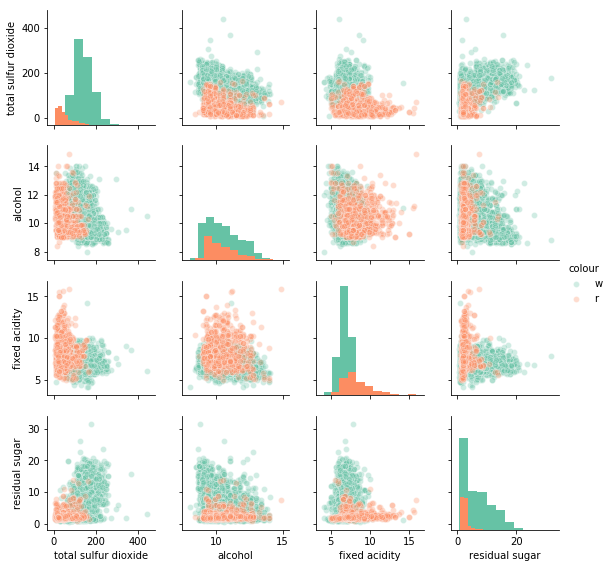

In [19]:
sns.pairplot(
    wine.sample(frac=.5), 
    hue= 'colour', 
    vars= ['total sulfur dioxide', 
           'alcohol','fixed acidity', 
           'residual sugar'],
    height=2,
    diag_kind='hist',
    plot_kws=dict(alpha=0.3)
)
plt.show()

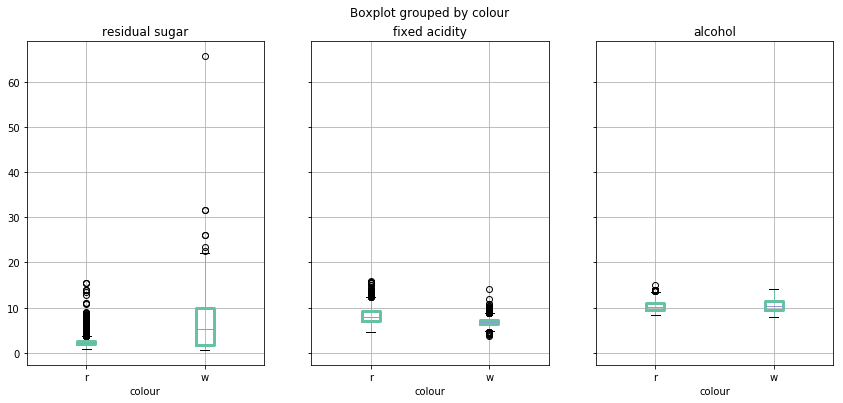

In [18]:
boxprops = dict(linewidth=3)
wine.boxplot(
    column=['residual sugar', 'fixed acidity', 'alcohol'], 
    by='colour', 
    boxprops=boxprops, 
    figsize=(14,6), 
    layout=(1,3)
)
plt.show()

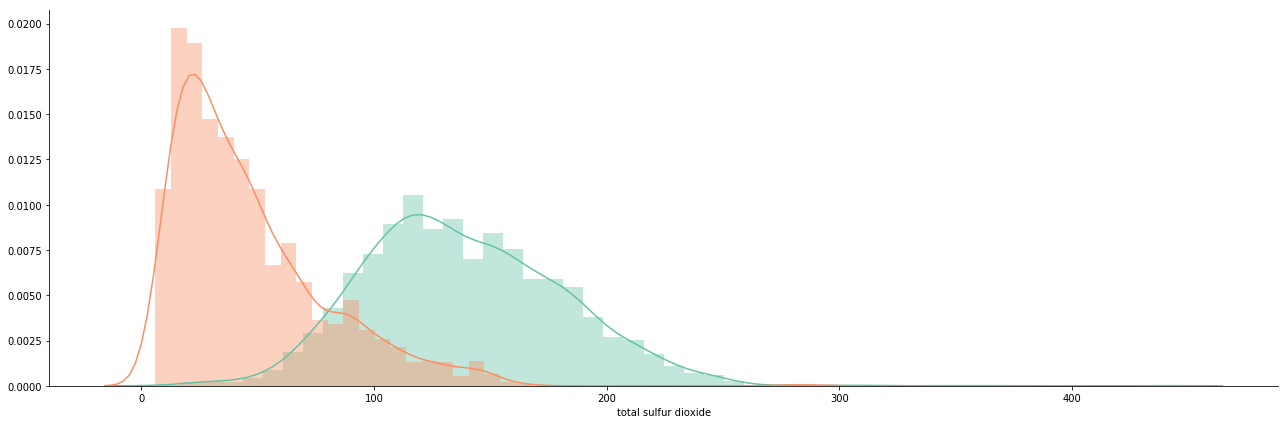

In [19]:
g = sns.FacetGrid(wine, hue='colour', height=6, aspect=3)
g.map(sns.distplot, "total sulfur dioxide")
plt.show()

**Feature engineering**

In the data exploration and cleaning phase, I also perform feature engineering. Feature engineering is the construction of new features from old features. Some basic types of feature engineering would be to create interaction variables from two features or to create lagged variables for time series analysis.

### 4. Model the data

----

Whenever I start the modelling part of the project I initially start by creating a **baseline model**. This can be thought of as fitting the simplest model possible to the data to provide a **starting point to improve from**. 

The most naive way of doing this in a classification problem would be to determine the accuracy of our model if we just predicted the most common class the whole time.

In [20]:
wine.colour.value_counts()

w    4898
r    1599
Name: colour, dtype: int64

In [21]:
(wine['colour']== 'w').mean()

0.7538864091118977

People also often use a simple linear model as a baseline model, such as a linear regression for a regression problem or a logistic regression for a classification problem.

When it comes to selecting which algorithm to use you will need to use your knowledge and experience to determine which models are appropriate for the data you have and for the problem you are solving. You will need to think about things such as whther your data is linear or not, or whether you are working in high dimensional space or with sparse matrices. 

We will be using a python machine learning package called Scikit-Learn. We can use Scikit-Learn for modeling (classification, regression, and clustering). It can also be used for dimensionality reduction (Principal Component Analysis), model selection (grid search, evaluation metrics), and preprocessing data. A huge benefit of Scikit-Learn is that the process we follow when modelling is very similar across different algorithms.

#### K-Nearest Neighbours

KNN is one of the simplest classification algorithms  
  * Non parametric 
  * Lazy learning 
  
KNN Algorithm is based on feature similarity: How closely out-of-sample features resemble our training set determines how we classify a given data point

Let's build a simple model with two features to predict whther a wine is white or red. 

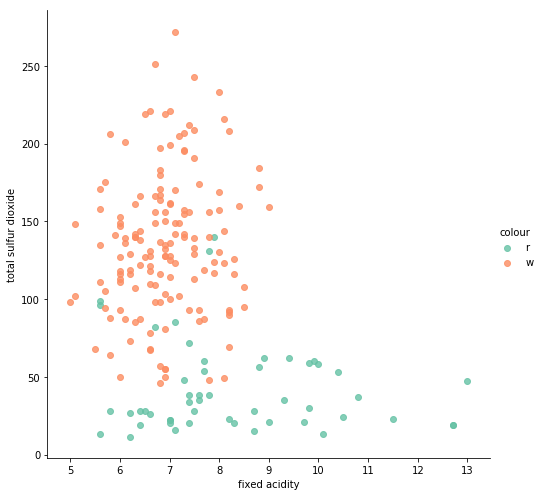

In [20]:
sns.lmplot(x='fixed acidity', y='total sulfur dioxide', hue='colour', data=wine.sample(200), fit_reg=False, height=7)
plt.show()

#### Pre-processing

You may need to take further pre-processing steps before you can start modelling to ensure your data is in a appropriate format. This will definitely be true if your dealing with unstructured data, like text data. 
We will need to separate out our features from our variable we are predicting and use a train-test-split to prevent overfitting of our model. 

Overfitting is when our model has learnt the structure of the training data too well and has learnt the noise rather that key signals. When this happens when we feed the model new (unseen) data it's unlikely to perform very well. Creating a training-test-split helps to combat overfitting. 


In [21]:
X = wine[['fixed acidity', 'total sulfur dioxide']]
y = wine.colour.factorize()[0]

In [22]:
X_train, X_test, y_train, y_test = ms.train_test_split(
    X, y, test_size=0.3, random_state=42)

In [23]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(4547, 2) (4547,)
(1950, 2) (1950,)


#### Fitting a KNN model

We are going to **fit** our model on the **training data**. Then we are going to **test** our model by having it **predict** _y values_ for our *X_test* data. We can then evaluate how well our model performed by seeing how far off the _predicted y_ values were from the _actual y_ values.

In [24]:
knn_uniform = neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform')
knn_uniform.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

#### Evaluation 

How well did we classify wines in our test data as being red or white?

In [25]:
metrics.accuracy_score(y_test, knn_uniform.predict(X_test))

0.9271794871794872

We managed to successfully classify whether a wine was red or white 93% of the time. 

It's important at this stage to think back to the success criteria for the project and compare the performance of the model against that. 

Accuracy isn't the only metric you can use to analyse the results of a classification model. A confusion matrix can give us more information about how our model is performing.

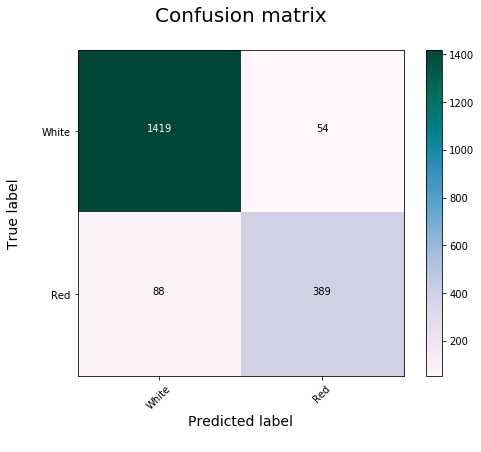

In [26]:
conmat = metrics.confusion_matrix(y_test, knn_uniform.predict(X_test))
plot_confusion_matrix(conmat, ["White", "Red"])

#### Gridsearching to select the best model parameters

In [27]:
params = {
    'weights': ['uniform', 'distance'],
    'n_neighbors': np.arange(2, 50)
}
three_fold_cv = ms.StratifiedKFold(n_splits=3, shuffle=True)
gs = ms.GridSearchCV(
    estimator=neighbors.KNeighborsClassifier(),
    param_grid=params,
    cv=three_fold_cv
)
gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'weights': ['uniform', 'distance'], 'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [28]:
gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=17, p=2,
           weights='uniform')

In [29]:
gs.best_score_

0.9342423575984166

In [30]:
metrics.accuracy_score(y_test, gs.best_estimator_.predict(X_test))

0.9317948717948717

#### What if we use more features?

In [31]:
X = wine[['fixed acidity', 'total sulfur dioxide', 'residual sugar', 'alcohol']]
y = wine.colour.factorize()[0]

X_train, X_test, y_train, y_test = ms.train_test_split(
    X, y, test_size=0.3, random_state=42)

In [34]:
knn_uniform = neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform')
knn_uniform.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [35]:
metrics.accuracy_score(y_test, knn_uniform.predict(X_test))

0.9441025641025641

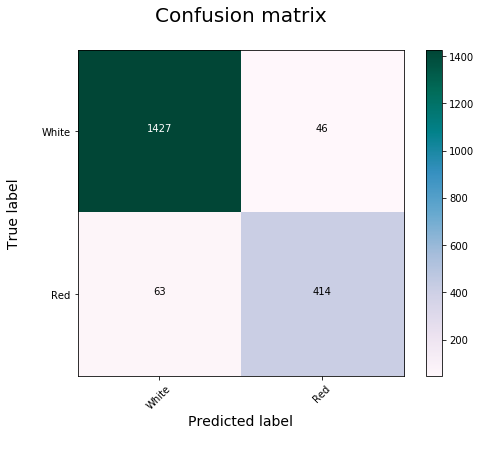

In [36]:
conmat = metrics.confusion_matrix(y_test, knn_uniform.predict(X_test))
plot_confusion_matrix(conmat, ["White", "Red"])

### 5. Communicating the results
---

You'll need to communicate the results of your model build process. You can showcase your results to the firm with a presentation and offer a technical overview on the process. Remember to keep your audience in mind. If you are presenting results to a room full of data scientists, go into detail. If you are advising the sales team, don’t get lost in the technical details before explaining your results. Give an overview of the technicals but focus of tying it back to how it has help to solve the business problem you were trying to solve. Finally, make sure you've reviewed the success criteria for your project and whether you've met it. 

Its also a good idea to ensure that you have documented the key decisions that have been made during the model build and also outline any assumptions or limitations of the model. Additionally, you should summarise what the next steps are for the model, perhaps there's a more complex algorithm you think would capture the relationships better, or a new feature that you think should be engineered. These ideas can then be picked up in future pieces of work.  


### Deploying the model

For some projects you might get the chance to operationalise the model you've built. You'll need to think aboout what changes need to be made to run the model in production. You should think about questions like: can the model handle real-time data, and how often will the model need to be retrained?  

### Useful resources

Pandas cheat sheet - https://github.com/pandas-dev/pandas/raw/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf

Pandas docs -
http://pandas.pydata.org/pandas-docs/stable/ 

sklearn model selection - http://scikit-learn.org/stable/tutorial/machine_learning_map/